## 프로젝트 : 네이버 영화리뷰 감성분석 도전하기
=========================================================================

# 목차

## 1. 데이터 준비 및 확인
## 2. 데이터 로더 구성
## 3. 데이터 분석 및 가공
## 4. 데이터셋 구성
## 5. 모델 구성 및 훈련, 시각화
## 6. 대표 모델 분석
## 7. 한국어 Word2Vec 임베딩 활용하여 성능 개선
## 8. 회고
## 9. Reference
## 10. 자기다짐 및 아쉬운 점

---

## 루브릭 달성 조건
- 1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다.
    - 3가지 이상의 모델이 성공적으로 시도됨
    
    
- 2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다.
    - gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함
   
   
- 3. 한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다.
   - 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함
   
---

## 1. 데이터 준비와 확인

In [1]:
import pandas as pd
import konlpy
import gensim
import tensorflow as tf
from konlpy.tag import Mecab
import numpy as np
from collections import Counter
import os
import matplotlib.pyplot as plt

tf.random.set_seed(42)

- 가장 먼저 사용할 라이브러리 및 모듈들을 불러오겠습니다.
  
  
- 앞으로 사용할 seed 또한 42로 고정해주겠습니다.

In [2]:
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

In [3]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [4]:
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


- 확인해보니 train, test 데이터 모두 id, document, label로 구성되어 있습니다.
  
  
- 이 데이터들을 이용하여 데이터 로더를 구성해 보겠습니다.

---
## 2. 데이터 로더 구성

In [5]:
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True) # 중복된 행 제거
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화, 한글을 나눠줌
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000)
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
x_train, y_train, x_test, y_test, word_to_index = load_data(train_data, test_data) 

index_to_word = {index:word for word, index in word_to_index.items()}

- 데이터를 가공하는 함수입니다.
  
  
- 가장 먼저 Mecab을 이용해줍니다.
- __Mecab이란__ 한글 형태소 분석기로 한글 토큰화하는데 가장 적합하다고 알려져 있다.
  
  
- 그리고 drop_duplicates 함수를 이용하여 중복된 행들을 제거해줍니다.
- 그 후에 중복된 데이터 삭제로 인해 생긴 nan 값들을 dropna 함수를 이용하여 제거합니다.
  
  
- 그리고 우리에게 필요한 document 컬럼을 이용하여 한글 토큰화 함수인 morphs를 이용하여 토큰화해줍니다. 이 때 데이터에 영향을 주지 않는 불용어(stopwords)를 제외한 후 토큰화하여 길이를 조절해 줍니다.
  
  
- morphs 란?

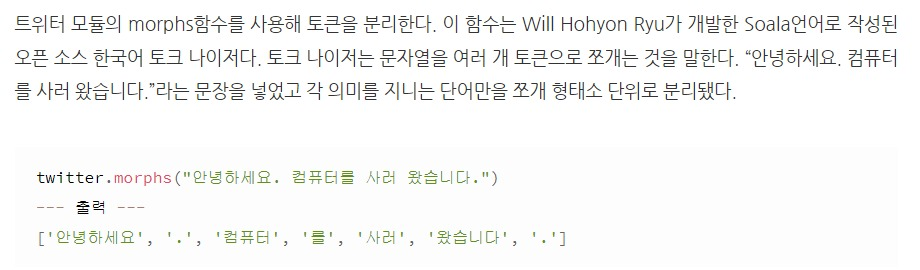
  
  
- 그 후 np.concatenate를 이용하여 행렬을 합쳐주고 tolist 함수를 이용해 리스트 형태로 변환하여 words 변수에 저장하였습니다.
  
  
- collection 모듈의 counter 함수를 이용하여 각 토큰 별 중복 카운트를 세 준 후 most_common을 이용해 10000개의 가장 빈도수가 높은 단어를 추출합니다.
  
  
- 그 후 word_to_index(단어:인덱스) 형태로 enumerate 함수를 이용하여 구해줍니다. 
  
  
- 위 과정을 통해 정제된 데이터를 list의 형태로 각각 x_train, x_test에 할당한 후 label 컬럼만 따로 추출하여 y_train, y_test에 할당하여 word_to_indx와 함께 리턴해 반환하였습니다.
  
  
- 그 후 word_to_index의 반대인 index_to_wrod 또한 딕셔너리형태로 만들어 줍니다.

---
## 3. 데이터 분석 및 가공

In [6]:
print('1번째 리뷰 문장 길이: ', len(x_train[0]))
print('2번째 리뷰 문장 길이: ', len(x_train[1]))

1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [7]:
print(index_to_word[1356])
print(len(index_to_word))

코
10001


- index_to_word에 잘 할당이 된 모습을 볼 수 있습니다.
  
  
- 이제 데이터의 길이을 통일하기위해 리뷰의 평균단어길이를 구해 전체 길이를 조절하겠습니다.

In [8]:
length = 0

for i in range(len(x_train)-1):
    length += len(x_train[i])
    
mean = round(length / len(x_train), 0)

mean = int(mean)

print('평균:' ,mean)

평균: 16


- 평균 리뷰의 길이가 16이군요. 모든 리뷰의 길이를 16으로 맞춰주겠습니다.

In [9]:
train_16 = []
y_16 = []
test_16 = []
y_test_16 = []

for i in range(len(x_train)):
    if len(x_train[i]) > 16:
        continue
    elif len(x_train[i]) <= 16:
        train_16.append(x_train[i])
        y_16.append(y_train[i])
        
for i in range(len(x_test)):
    if len(x_test[i]) > 16:
        continue
    elif len(x_test[i]) <= 16:
        test_16.append(x_train[i])
        y_test_16.append(y_train[i])    

In [10]:
print(len(x_train))
print(len(y_train))

146182
146182


In [11]:
print(len(train_16))
print(len(y_16))

98044
98044


- 길이 조절을 해줬더니 거의 5만개에 가까운 데이터가 삭제됐습니다.
  
  
- 데이터가 너무 짧아진게 아닌가.. 하는 걱정이 듭니다.

In [12]:
x_train = train_16
y_train = y_16
x_test = test_16
y_test = y_test_16

- 위에서 구해준 데이터들을 다시 원 위치에 재할당해주었습니다.

In [13]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>


- 모든 데이터의 타입이 list 인것을 확인할 수 있습니다.
  
  
- 이제 패딩작업을 통해 다시 한번 데이터들의 길이를 평균값으로 맞춰주겠습니다.

In [14]:
x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train, maxlen=mean, padding='pre')
x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test, maxlen=mean, padding='pre')

In [15]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
<class 'list'>


- 근데 패딩작업을 해주니 numpy 행렬형태로 변하였군요. 이러면 모델 학습이 불가능해집니다. 똑같이 라벨 데이터도 numpy 형태로 변형해 주겠습니다.

In [16]:
y_train = np.array(y_train)
y_test = np.array(y_test)

In [17]:
print(type(x_train))
print(type(y_train))
print(type(x_test))
print(type(y_test))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


- 이제 형태가 일치하게 된것을 확인할 수가 있습니다.

---
## 4. 데이터셋 구성

In [18]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train,
                                                  y_train,
                                                  test_size=0.2,
                                                  random_state=42)

In [19]:
print(' 훈련 데이터셋의 길이: ',len(x_train),'\n', '벨리데이션 데이터셋의 길이: ', len(x_val))
print(' 훈련 라벨데이터셋의 길이: ', len(y_train), '\n', '벨리데이션 라벨데이터셋의 길이: ', len(y_val))

 훈련 데이터셋의 길이:  78435 
 벨리데이션 데이터셋의 길이:  19609
 훈련 라벨데이터셋의 길이:  78435 
 벨리데이션 라벨데이터셋의 길이:  19609


- train 데이터와 validation 데이터가 잘 구분되었습니다.
- 모델 구성을 시작해보도록 하겠습니다.

---
## 5. 모델 구성 및 훈련, 시각화

In [20]:
vocab_size = 10000  # 어휘 사전의 크기입니다
word_vector_dim = 40  # 단어 하나를 표현하는 임베딩 벡터의 차원수입니다. 
batch_size = 512
epochs = 10 # 학습량

- 공통으로 사용할 하이퍼 파라미터들을 지정해주었습니다.

In [21]:
model_00 = tf.keras.Sequential()
model_00.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_00.add(tf.keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model_00.add(tf.keras.layers.Dense(8, activation='relu'))
model_00.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_00.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 40)          400000    
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1568      
_________________________________________________________________
dense (Dense)                (None, 8)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 401,649
Trainable params: 401,649
Non-trainable params: 0
_________________________________________________________________


In [22]:
model_00.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_00 = model_00.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose='auto')

Epoch 1/10
154/154 [==============================] - 5s 8ms/step - loss: 0.5410 - accuracy: 0.7692 - val_loss: 0.4049 - val_accuracy: 0.8275
Epoch 2/10
154/154 [==============================] - 1s 5ms/step - loss: 0.3534 - accuracy: 0.8533 - val_loss: 0.3747 - val_accuracy: 0.8389
Epoch 3/10
154/154 [==============================] - 1s 5ms/step - loss: 0.3188 - accuracy: 0.8705 - val_loss: 0.3764 - val_accuracy: 0.8378
Epoch 4/10
154/154 [==============================] - 1s 5ms/step - loss: 0.3024 - accuracy: 0.8779 - val_loss: 0.3765 - val_accuracy: 0.8388
Epoch 5/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2909 - accuracy: 0.8833 - val_loss: 0.3802 - val_accuracy: 0.8408
Epoch 6/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2784 - accuracy: 0.8891 - val_loss: 0.3836 - val_accuracy: 0.8363
Epoch 7/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2653 - accuracy: 0.8953 - val_loss: 0.3939 - val_accuracy: 0.8357
Epoch 

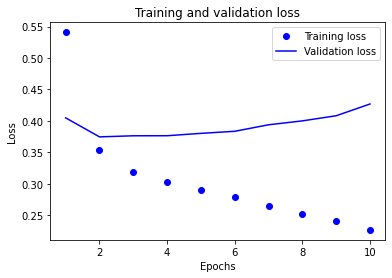

In [23]:
history_dict = history_00.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epoch, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

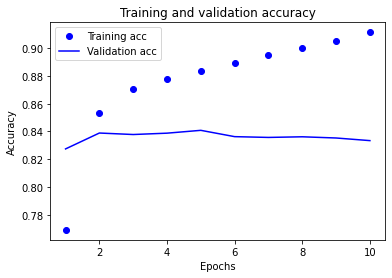

In [24]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epoch, acc, 'bo', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
model_01 = tf.keras.Sequential()
model_01.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model_01.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model_01.add(tf.keras.layers.MaxPooling1D(5))
model_01.add(tf.keras.layers.Conv1D(16, 2, activation='relu'))
model_01.add(tf.keras.layers.GlobalMaxPooling1D())
model_01.add(tf.keras.layers.Dense(8, activation='relu'))
model_01.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model_01.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1296      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          528       
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [26]:
model_01.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_01 = model_01.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose='auto')

Epoch 1/10
154/154 [==============================] - 3s 7ms/step - loss: 0.5220 - accuracy: 0.7481 - val_loss: 0.3806 - val_accuracy: 0.8302
Epoch 2/10
154/154 [==============================] - 1s 5ms/step - loss: 0.3304 - accuracy: 0.8607 - val_loss: 0.3636 - val_accuracy: 0.8433
Epoch 3/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2823 - accuracy: 0.8851 - val_loss: 0.3668 - val_accuracy: 0.8425
Epoch 4/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2457 - accuracy: 0.9046 - val_loss: 0.3855 - val_accuracy: 0.8385
Epoch 5/10
154/154 [==============================] - 1s 5ms/step - loss: 0.2125 - accuracy: 0.9204 - val_loss: 0.4064 - val_accuracy: 0.8370
Epoch 6/10
154/154 [==============================] - 1s 5ms/step - loss: 0.1809 - accuracy: 0.9340 - val_loss: 0.4424 - val_accuracy: 0.8340
Epoch 7/10
154/154 [==============================] - 1s 5ms/step - loss: 0.1527 - accuracy: 0.9462 - val_loss: 0.4786 - val_accuracy: 0.8269
Epoch 

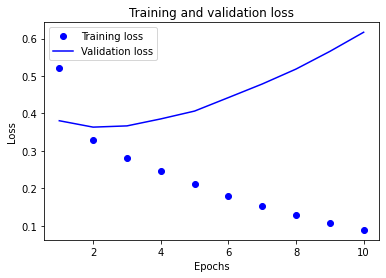

In [27]:
history_dict = history_01.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epoch = range(1, len(acc) + 1)

plt.plot(epoch, loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

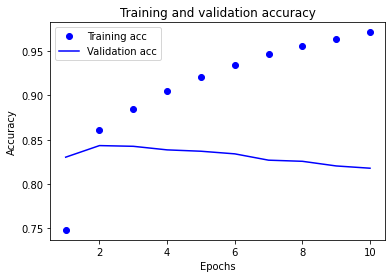

In [28]:
plt.clf()

plt.plot(epoch, acc, 'bo', label='Training acc')
plt.plot(epoch, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 위 데이터셋들은 LMS에서 가져온 예시 코드입니다.
- 데이터들의 결과를 보니 어느정도부터 벨리데이션 데이터의 loss는 상승하고 acc는 정체되는 모습을 보여주고 있습니다.
  
  
- 이제 제 모델을 만들어보도록 하겠습니다.

In [29]:
my_model_LSTM = tf.keras.Sequential()
my_model_LSTM.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,  input_shape=(None,)))
my_model_LSTM.add(tf.keras.layers.LSTM(units = 80, return_sequences=True, dropout=0.5))
my_model_LSTM.add(tf.keras.layers.LSTM(units = 40, return_sequences=True, dropout=0.3))
my_model_LSTM.add(tf.keras.layers.LSTM(units = 16, dropout=0.3))
my_model_LSTM.add(tf.keras.layers.BatchNormalization())
my_model_LSTM.add(tf.keras.layers.Dense(units = 16, activation='relu'))
my_model_LSTM.add(tf.keras.layers.Dense(units = 8, activation='relu'))
my_model_LSTM.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

my_model_LSTM.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 80)          38720     
_________________________________________________________________
lstm_2 (LSTM)                (None, None, 40)          19360     
_________________________________________________________________
lstm_3 (LSTM)                (None, 16)                3648      
_________________________________________________________________
batch_normalization (BatchNo (None, 16)                64        
_________________________________________________________________
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                

- 아직 아는 모델이 없어.. 일단 자주 사용했던 Sequential 모델로 구성하였습니다.
  
  
- Embedding 층에 하이퍼파라미터들로 구성하여 단어장의 크기, 표현할 단어 임베딩의 갯수를 지정해주었습니다.
  
  
- 아래 LSTM층을 3층으로 쌓았는데 각각 units을 80, 40, 16으로 점점 낮춰가며 지정을 하였고 1,2층엔 return_sequences를 True로 놓아 sequence들이 다음 층까지 영향을 줄 수 있도록 설정하였습니다. 
- 또한 연습과정에서 자꾸 발생하는 overfitting을 해결하기 위해 dropout 파라미터를 이용하여 어느정도 해결하였습니다.
  
  
- LSTM 다음층으론 BatchNormalization 층을 두어 한번 더 overfitting에 대비하였습니다.
  
  
- Dense층 또한 3층으로 구성하였고 마지막층에선 units을 1, 활성화함수를 sigmoid함수를 사용하여 이진분류 방법을 통해 리뷰 데이터의 긍정, 부정에 대한 이진분류를 할 수 있도록 설정하였습니다.

#### Dense층이란?
- 아직 Dense층에 관하여 제대로 공부하지 못했기 때문에 이번에 한번 공부해보았습니다.

- Dense층이란 입출력을 연결해주는 레이어라고 합니다.
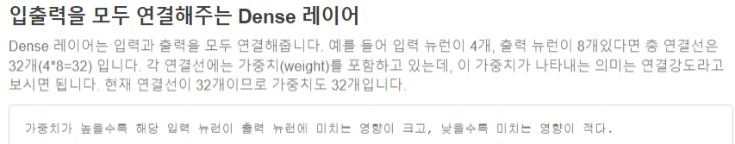

- Dense층은 입력 뉴런 수와 상관없이 출력 뉴런 수를 자유롭게 설정할 수 있기 때문에 출력층으로 많이 사용된다.
  
  
- 주로 이진분류일 때 sigmoid를 활성화 함수로 많이 사용하게 된다. 
- 도식화한 그림은 아래와 같다.

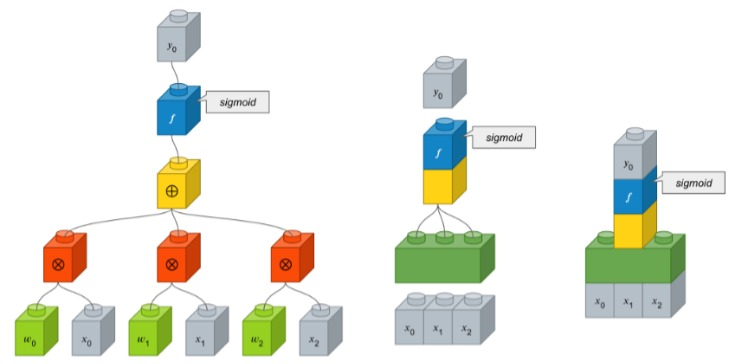



- 다중분류일땐 softmax를 활성화 함수를 사용한다.

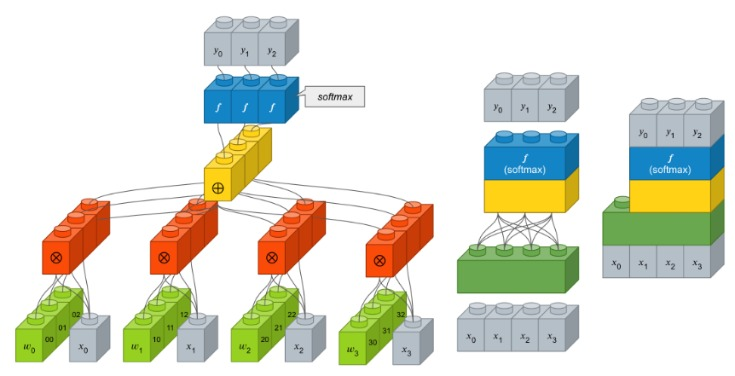

- 또한 출력층 이전의 은닉층으로도 많이 쓰이고 수치자료사용시에는 입력층으로도 많이 쓰입니다. 이땐 relu 를 주로 사용합니다.

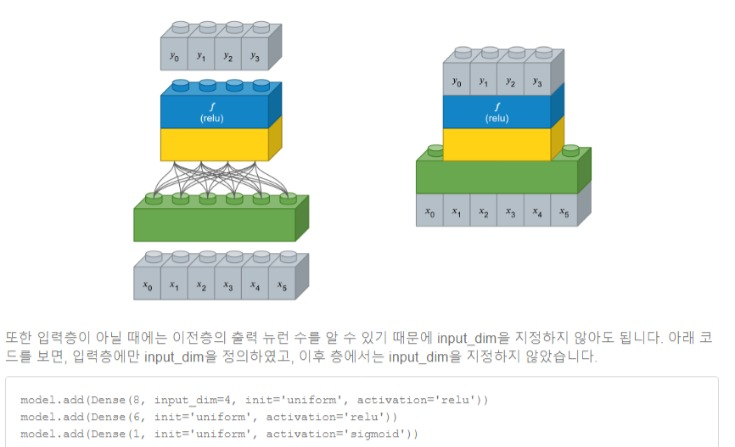

- 결국 dense층은 입력,은닉,출력층 모두 할 수 있는 층이다.


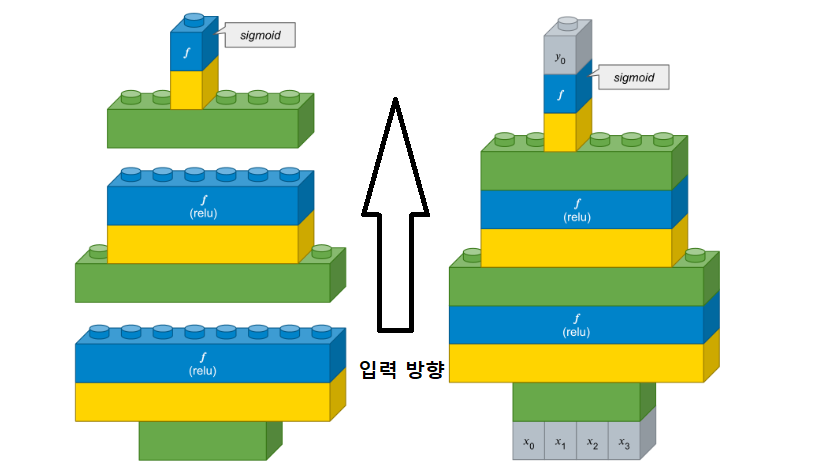

- LSTM 모델을 학습시켜보도록 하겠습니다.

In [30]:
my_model_LSTM.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_history_LSTM = my_model_LSTM.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose='auto')

Epoch 1/10
154/154 [==============================] - 7s 16ms/step - loss: 0.4778 - accuracy: 0.7592 - val_loss: 0.5994 - val_accuracy: 0.7023
Epoch 2/10
154/154 [==============================] - 2s 10ms/step - loss: 0.3600 - accuracy: 0.8417 - val_loss: 0.4709 - val_accuracy: 0.8386
Epoch 3/10
154/154 [==============================] - 2s 10ms/step - loss: 0.3316 - accuracy: 0.8565 - val_loss: 0.4051 - val_accuracy: 0.8342
Epoch 4/10
154/154 [==============================] - 2s 10ms/step - loss: 0.3141 - accuracy: 0.8651 - val_loss: 0.3848 - val_accuracy: 0.8324
Epoch 5/10
154/154 [==============================] - 2s 10ms/step - loss: 0.2972 - accuracy: 0.8737 - val_loss: 0.3698 - val_accuracy: 0.8379
Epoch 6/10
154/154 [==============================] - 2s 10ms/step - loss: 0.2858 - accuracy: 0.8795 - val_loss: 0.3762 - val_accuracy: 0.8354
Epoch 7/10
154/154 [==============================] - 2s 10ms/step - loss: 0.2753 - accuracy: 0.8825 - val_loss: 0.4068 - val_accuracy: 0.8374

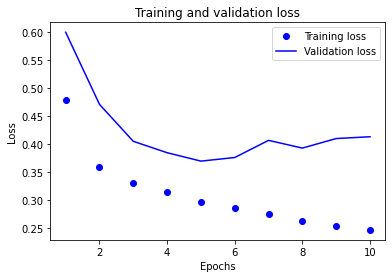

In [31]:
LSTM_history_dict = my_history_LSTM.history

LSTM_acc = LSTM_history_dict['accuracy']
LSTM_val_acc = LSTM_history_dict['val_accuracy']
LSTM_loss = LSTM_history_dict['loss']
LSTM_val_loss = LSTM_history_dict['val_loss']

LSTM_epochs = range(1, len(LSTM_acc) + 1)

plt.plot(LSTM_epochs, LSTM_loss, 'bo', label='Training loss')
plt.plot(LSTM_epochs, LSTM_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- loss가 점점 하락하는 모습을 보여줍니다.
- validation의 loss가 잠깐 상승하는 모습을 보여주나 기존의 overfitting에 비하여 어느정도 나아진 모습을 보여줍니다.

#### 기존의 overfittng

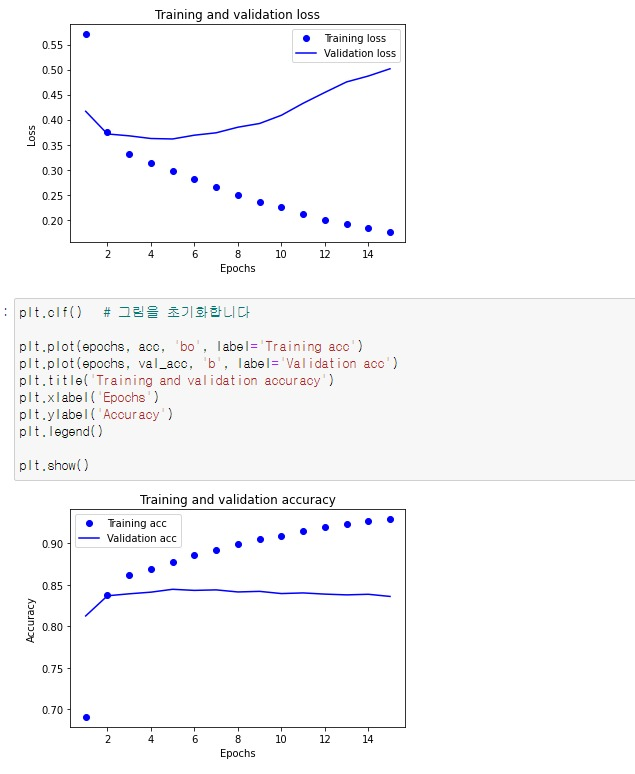

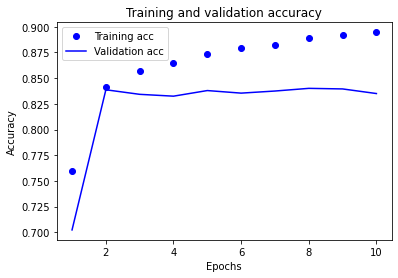

In [32]:
plt.clf()

plt.plot(LSTM_epochs, LSTM_acc, 'bo', label='Training acc')
plt.plot(LSTM_epochs, LSTM_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 정확도 또한 상승하는 모습을 보여주나 5 epoch 이후로는 정체되는 모습을 보여줍니다. 아직 overfitting을 완벽하게 해결하지는 못한것 같습니다.
  
  
- 다른 모델을 통해 다시 한번 시도해보겠습니다.

In [33]:
my_model_GRU = tf.keras.Sequential()
my_model_GRU.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim,  input_shape=(None,)))
my_model_GRU.add(tf.keras.layers.GRU(units = 80, return_sequences=True, dropout=0.5))
my_model_GRU.add(tf.keras.layers.GRU(units = 40, return_sequences=True, dropout=0.3))
my_model_GRU.add(tf.keras.layers.GRU(units = 16, dropout=0.3))
my_model_GRU.add(tf.keras.layers.BatchNormalization())
my_model_GRU.add(tf.keras.layers.Dense(units = 16, activation='relu'))
my_model_GRU.add(tf.keras.layers.Dense(units = 8, activation='relu'))
my_model_GRU.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

my_model_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 40)          400000    
_________________________________________________________________
gru (GRU)                    (None, None, 80)          29280     
_________________________________________________________________
gru_1 (GRU)                  (None, None, 40)          14640     
_________________________________________________________________
gru_2 (GRU)                  (None, 16)                2784      
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 8)                

- 이번엔 아까와 동일한 LSTM 모델에 GRU층만 대입하여 구성하였습니다.

#### GRU란?
- GRU(Gated Recrurent Unit) 이며 LSTM과 같이 RNN의 장기 의존성 문제를 해결하기 위한 알고리즘으로 LSTM과 구조가 크게 다르진 않지만 LSTM에 비해 output gate가 없는 구조이기 때문에 매개변수가 적다.
  
  
- 성능은 LSTM과 유사하지만 소규모 데이터 세트에서는 더 나은 성능을 보여준다.

- 유사하다고 합니다만 사실 둘간의 성능차이가 명확하지는 않다고 합니다.
- 한번 비교해보도록 하겠습니다.

In [34]:
my_model_GRU.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_history_GRU = my_model_GRU.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose='auto')

Epoch 1/10
154/154 [==============================] - 6s 15ms/step - loss: 0.4882 - accuracy: 0.7515 - val_loss: 0.5082 - val_accuracy: 0.8349
Epoch 2/10
154/154 [==============================] - 2s 10ms/step - loss: 0.3599 - accuracy: 0.8440 - val_loss: 0.3843 - val_accuracy: 0.8377
Epoch 3/10
154/154 [==============================] - 1s 10ms/step - loss: 0.3302 - accuracy: 0.8565 - val_loss: 0.3749 - val_accuracy: 0.8365
Epoch 4/10
154/154 [==============================] - 1s 10ms/step - loss: 0.3116 - accuracy: 0.8655 - val_loss: 0.3989 - val_accuracy: 0.8276
Epoch 5/10
154/154 [==============================] - 1s 10ms/step - loss: 0.2971 - accuracy: 0.8723 - val_loss: 0.3771 - val_accuracy: 0.8377
Epoch 6/10
154/154 [==============================] - 1s 10ms/step - loss: 0.2832 - accuracy: 0.8785 - val_loss: 0.3774 - val_accuracy: 0.8398
Epoch 7/10
154/154 [==============================] - 1s 10ms/step - loss: 0.2737 - accuracy: 0.8840 - val_loss: 0.3988 - val_accuracy: 0.8240

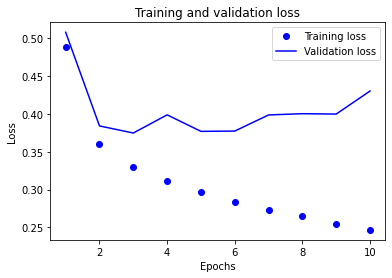

In [35]:
GRU_history_dict = my_history_GRU.history

GRU_acc = GRU_history_dict['accuracy']
GRU_val_acc = GRU_history_dict['val_accuracy']
GRU_loss = GRU_history_dict['loss']
GRU_val_loss = GRU_history_dict['val_loss']

GRU_epochs = range(1, len(GRU_acc) + 1)

plt.plot(GRU_epochs, GRU_loss, 'bo', label='Training loss')
plt.plot(GRU_epochs, GRU_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

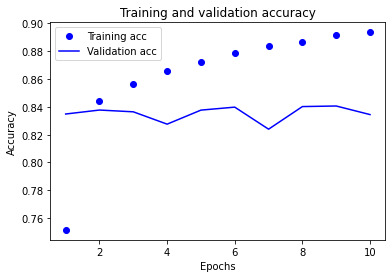

In [36]:
plt.clf()

plt.plot(GRU_epochs, GRU_acc, 'bo', label='Training acc')
plt.plot(GRU_epochs, GRU_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 여전히 overfitting을 제대로 해결하지 못한 모습을 보여줍니다.
- LSTM과 함께 비교해 보겠습니다.

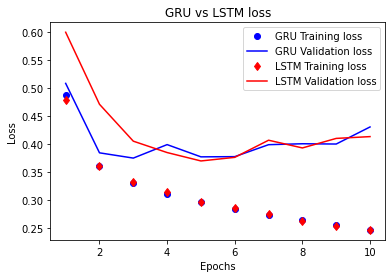

In [37]:
plt.plot(GRU_epochs, GRU_loss, 'bo', label='GRU Training loss')
plt.plot(GRU_epochs, GRU_val_loss, 'b', label='GRU Validation loss')
plt.plot(LSTM_epochs, LSTM_loss, 'rd', label='LSTM Training loss')
plt.plot(LSTM_epochs, LSTM_val_loss, 'r', label='LSTM Validation loss')

plt.title('GRU vs LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 빨간색은 LSTM, 파란색은 GRU로 구분하였습니다.
  
  
- train loss는 거의 동일하나 validation loss가 LSTM이 더 좋은 모습을 보여주고있군요. 
  
- 그래도 둘다 loss도 점점 하락하는 모양을 보여주고 어느 기점에선 상승하기도 하나 학습이 잘 되고있는것 같습니다.  
  
- accuracy도 확인해보겠습니다.

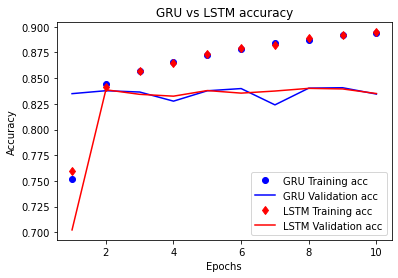

In [38]:
plt.clf()

plt.plot(GRU_epochs, GRU_acc, 'bo', label='GRU Training acc')
plt.plot(GRU_epochs, GRU_val_acc, 'b', label='GRU Validation acc')
plt.plot(LSTM_epochs, LSTM_acc, 'rd', label='LSTM Training acc')
plt.plot(LSTM_epochs, LSTM_val_acc, 'r', label='LSTM Validation acc')

plt.title('GRU vs LSTM accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- GRU 데이터는 거의 validation의 accuracy가 고정되어있는듯한 모습을 보입니다만 LSTM은 함께 상승하는 모양을 보여줍니다. 
  
  
- 그래도 둘 다 train 데이터는 정확도가 90%에 근접하고 validation 데이터도 정확도가 85% 에 근접하는 상당히 높은 수치를 보여주고 있습니다.
  
  
- 학습은 잘 되고있는듯한 모습을 보여줍니다.
  
  
- train의 accuracy는 거의 차이가 없군요
  
  
- 제 생각으론 LSTM을 대표 모델로 분석하는게 더 좋아보입니다.

---
## 6. 대표 모델 분석

- 이제 학습한 데이터를 토대로 word2vec을 이용하여 분석해보겠습니다.

In [39]:
word2vec_file_path = os.getenv('HOME')+'/aiffel/exp/08_emotion/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim))

vectors = my_model_LSTM.get_weights()[0]
for i in range(3, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 데이터의 0, 1, 2번은 비어있는 데이터기 때문에 범위에서 제외하였습니다.

- word2vec이란 txt파일에 학습 데이터를 저장하였습니다. 불러와서 확인해보곘습니다.

In [40]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

my_word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)

In [41]:
my_word_vectors.similar_by_word("시작")

[('고는', 0.6591456532478333),
 ('골든', 0.645539402961731),
 ('사토시', 0.6428443193435669),
 ('김강우', 0.6427414417266846),
 ('2012', 0.6416478753089905),
 ('경쾌', 0.6242234706878662),
 ('정확히', 0.6241530179977417),
 ('붙', 0.6182334423065186),
 ('영화제', 0.6177629828453064),
 ('볼까', 0.6167010068893433)]

- 음... 유사한 단어를 확인하고자 한건데.. 너무나도 틀렸군요..?
  
  
- 시작과 전혀 연관없는 오르, 영화제 같은 단어들이 최상단에 뜹니다.
- accuracy 같은 지표들은 좋은 지표를 보여줬는데.. 이상하군요.
- 더 좋은 모델을 쓰면 다를까요? 제공된 데이터셋을 이용해 보겠습니다.

---
## 7. 한국어 Word2Vec 임베딩 활용하여 성능 개선

In [42]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word2vec_path = os.getenv('HOME')+'/aiffel/exp/08_emotion/data/data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [43]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원수
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩마다 차례차례 카피한다.
for i in range(3,vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

- 새로운 모델에 Embedding 에 사용할 데이터를 직전 학습데이터에서 가져옵니다.

In [44]:
from tensorflow.keras.initializers import Constant

vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 100  # 워드 벡터의 차원 수 

# 모델 구성
my_model_korea = tf.keras.Sequential()
my_model_korea.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, embeddings_initializer=Constant(embedding_matrix), input_length=mean, trainable=True))
my_model_korea.add(tf.keras.layers.LSTM(units = 80, return_sequences=True, dropout=0.5))
my_model_korea.add(tf.keras.layers.LSTM(units = 40, return_sequences=True, dropout=0.3))
my_model_korea.add(tf.keras.layers.LSTM(units = 16, dropout=0.3))
my_model_korea.add(tf.keras.layers.BatchNormalization())
my_model_korea.add(tf.keras.layers.Dense(units = 16, activation='relu'))
my_model_korea.add(tf.keras.layers.Dense(units = 8, activation='relu'))
my_model_korea.add(tf.keras.layers.Dense(units = 1, activation='sigmoid'))

my_model_korea.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 16, 100)           1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 16, 80)            57920     
_________________________________________________________________
lstm_5 (LSTM)                (None, 16, 40)            19360     
_________________________________________________________________
lstm_6 (LSTM)                (None, 16)                3648      
_________________________________________________________________
batch_normalization_2 (Batch (None, 16)                64        
_________________________________________________________________
dense_10 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_11 (Dense)             (None, 8)                

- 이전 데이터를 Embedding층에 사용한 것을 제외하면 모델은 동일하게 구성하였습니다. 
  
  
- 학습시켜보도록 하겠습니다.

In [45]:
my_model_korea.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

my_history_korea = my_model_korea.fit(x_train,
                    y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    verbose='auto')

Epoch 1/10
154/154 [==============================] - 6s 16ms/step - loss: 0.6158 - accuracy: 0.6510 - val_loss: 0.5813 - val_accuracy: 0.7310
Epoch 2/10
154/154 [==============================] - 2s 10ms/step - loss: 0.5249 - accuracy: 0.7373 - val_loss: 0.4682 - val_accuracy: 0.7862
Epoch 3/10
154/154 [==============================] - 2s 10ms/step - loss: 0.4749 - accuracy: 0.7721 - val_loss: 0.4248 - val_accuracy: 0.8070
Epoch 4/10
154/154 [==============================] - 2s 10ms/step - loss: 0.4425 - accuracy: 0.7905 - val_loss: 0.3964 - val_accuracy: 0.8208
Epoch 5/10
154/154 [==============================] - 2s 10ms/step - loss: 0.4204 - accuracy: 0.8052 - val_loss: 0.3898 - val_accuracy: 0.8264
Epoch 6/10
154/154 [==============================] - 2s 10ms/step - loss: 0.4036 - accuracy: 0.8146 - val_loss: 0.3787 - val_accuracy: 0.8315
Epoch 7/10
154/154 [==============================] - 2s 10ms/step - loss: 0.3910 - accuracy: 0.8198 - val_loss: 0.3759 - val_accuracy: 0.8369

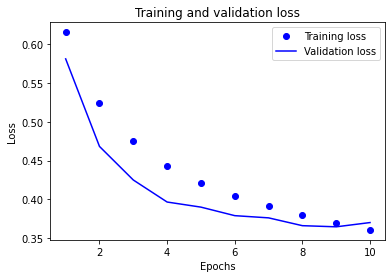

In [46]:
korea_history_dict = my_history_korea.history

korea_acc = korea_history_dict['accuracy']
korea_val_acc = korea_history_dict['val_accuracy']
korea_loss = korea_history_dict['loss']
korea_val_loss = korea_history_dict['val_loss']

korea_epochs = range(1, len(korea_acc) + 1)

plt.plot(korea_epochs, korea_loss, 'bo', label='Training loss')
plt.plot(korea_epochs, korea_val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

- 제가 만든 데이터와는 확연하게 다른 그래프를 보여줍니다.
- overfitting이 해결된 모습을 보여줍니다.

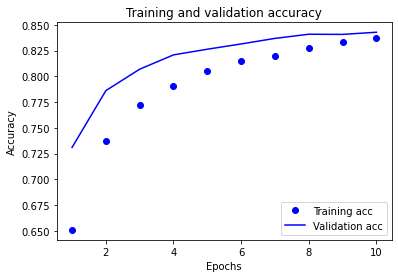

In [47]:
plt.clf()   # 그림을 초기화합니다

plt.plot(korea_epochs, korea_acc, 'bo', label='Training acc')
plt.plot(korea_epochs, korea_val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- accuracy 또한 상당한 모습을 보여주고있습니다.85% 수준의 정확도를 보여주며 overfitting의 모습을 거의 보여주지 않고있습니다.

- 한번 대표모델과 비교해볼까요?

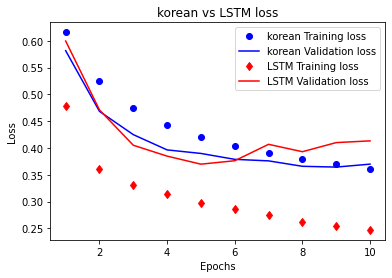

In [48]:
plt.plot(korea_epochs, korea_loss, 'bo', label='korean Training loss')
plt.plot(korea_epochs, korea_val_loss, 'b', label='korean Validation loss')
plt.plot(LSTM_epochs, LSTM_loss, 'rd', label='LSTM Training loss')
plt.plot(LSTM_epochs, LSTM_val_loss, 'r', label='LSTM Validation loss')

plt.title('korean vs LSTM loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

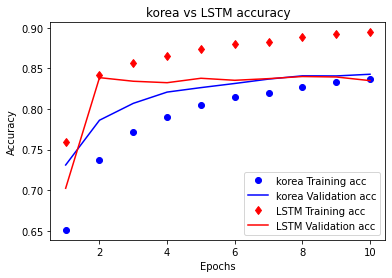

In [49]:
plt.clf()

plt.plot(korea_epochs, korea_acc, 'bo', label='korea Training acc')
plt.plot(korea_epochs, korea_val_acc, 'b', label='korea Validation acc')
plt.plot(LSTM_epochs, LSTM_acc, 'rd', label='LSTM Training acc')
plt.plot(LSTM_epochs, LSTM_val_acc, 'r', label='LSTM Validation acc')

plt.title('korea vs LSTM accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

- 함께 비교해보니 뭔가 이상합니다.. 비록 overfitting은 해결됬지만 더 낮은 정확도와 더 높은 loss를 가지고 있군요.
  
  
- 성능도 한번 확인해보겠습니다.

In [50]:
test_loss, test_acc = my_model_korea.evaluate(x_test, y_test, verbose='auto')

print('테스트 데이터셋 Loss: ', test_loss)
print('테스트 데이터셋 Accuracy: ', (test_acc*100),'%')

테스트 데이터셋 Loss:  0.34237170219421387
테스트 데이터셋 Accuracy:  85.63472628593445 %


- 그래도 85%에 가까운 정확도를 보유하고 있는게 확인됩니다.

In [51]:
korea_file_path = os.getenv('HOME')+'/aiffel/exp/08_emotion/data/koreaword2vec.txt'
f = open(korea_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-3, word_vector_dim)) # 몇개의 벡터를 얼마사이즈로 기재할지 정함

# 단어 개수(특수문자 3개를 제외하고) 워드벡터를 파일에 기록한다.
vectors = my_model_korea.get_weights()[0]
for i in range(3, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

- 다시 한번 유사한 단어들을 살펴보겠습니다.

In [52]:
korea_vectors = Word2VecKeyedVectors.load_word2vec_format(korea_file_path, binary=False)

In [53]:
korea_vectors.similar_by_word("실망")

[('당혹', 0.8191663026809692),
 ('당황', 0.8118172287940979),
 ('뻔뻔', 0.764638364315033),
 ('경악', 0.7248429656028748),
 ('분노', 0.7086954116821289),
 ('불쾌', 0.6813050508499146),
 ('지루', 0.6749668717384338),
 ('불평', 0.6730157136917114),
 ('후회', 0.6661884784698486),
 ('절망', 0.6619151830673218)]

- 그래도 성능이 많이 좋아졌습니다. '실망' 이라는 키워드로 검색하니 '당혹', '당황' 등의 감정적인 단어들이 나오는군요!
  
  
- 기존 모델과 비교해보겠습니다.

In [54]:
my_word_vectors.similar_by_word("사랑")

[('최고', 0.9374942183494568),
 ('올려야', 0.9109516739845276),
 ('www', 0.9098654389381409),
 ('겁니다', 0.8990537524223328),
 ('수작', 0.8973854184150696),
 ('친근', 0.8937578797340393),
 ('류덕환', 0.892206609249115),
 ('이뻐', 0.8921252489089966),
 ('멋지', 0.8913710713386536),
 ('놓칠', 0.8908158540725708)]

In [55]:
korea_vectors.similar_by_word("사랑")

[('이별', 0.7812283635139465),
 ('행복', 0.7726501226425171),
 ('슬픔', 0.7556366920471191),
 ('그리움', 0.7380250096321106),
 ('추억', 0.7318978905677795),
 ('꿈', 0.7252843976020813),
 ('마음', 0.7202531695365906),
 ('기쁨', 0.7121748328208923),
 ('애정', 0.7114666700363159),
 ('유혹', 0.7084570527076721)]

- 좋은 모델이 성능을 잘 이끌어내는게 맞는것같습니다.
  
  
- '사랑' 이라는 키워드에 이별, 행복, 슬픔 등등 연관성 있는 단어를 보여주는 모습을 볼 수 있습니다.

---
## 8. 회고

### 이번 프로젝트를 하면서 어려웠던 점
>- 이번 프로젝트에선 처음써보는 word2vec이라는 게 너무 어려웠습니다. 어떻게 이용하는지 저장, 불러오기 등 사실 아직도 원리가 정확하게 이해되진않습니다. 처음보는 함수도 많고 점점 함수들이 복잡하게 꼬여있어 직관적으로 알아보기가 매우 힘들었습니다.

### 이번 프로젝트에서 학습한 내용
>- 무엇인지 모르다보니 상당히 많이 알아봤습니다. 그동안 사용하던 Dense layer라던지 GRU layer, 모르던 함수들, NLP 관한 내용들을 알아보았습니다. 특히 overfitting을 해결하기 위한 방법들에 대해서 가장 많이 공부한것같습니다. 도움이 되었던 곳들은 Reference에 기재하겠습니다.

### 알아낸 점이나 모호한 점
>- BatchNormalization, dropout 등을 통한 overfitting을 해결하는 법에 대해 가장 많이 알게되었습니다.
>- 또한 아직 딥러닝 레이어를 쌓는법은 조금 모호합니다. 어느정도 느낌은 있으나 아직 설명하기 어렵고 정확한 레이어들의 원리에 대해서 아직 모르기 때문에 공부를 더 해야할 내용이라고 생각됩니다.

### 루브릭 평가지표를 맞추기 위해 노력했던 점
> - __1. 다양한 방법으로 Text Classification 태스크를 성공적으로 구현하였다. 3가지 이상의 모델이 성공적으로 시도됨__ 에 대해서는 성공적이었습니다. LMS에서 제공된 예제 모델 2개와 LSTM 모델, GRU 모델, 구글 데이터를 이용한 google 모델 까지 해서 총 5개의 모델을 시도한 결과 수치상으론 좋은 결과값을 얻었습니다. 하지만 실제 결과에 대해서는 좋지 않은 결과를 얻었습니다.
>- __2. gensim을 활용하여 자체학습된 혹은 사전학습된 임베딩 레이어를 분석하였다. gensim의 유사단어 찾기를 활용하여 자체학습한 임베딩과 사전학습 임베딩을 비교 분석함__ 에 대해서는 similar_by_word 함수를 이용하여 학습시킨 word2vec 텍스트와 word2vec_ko.model을 이용한 word2vec 텍스트 두 개를 서로 비교하였습니다.
>-__3.  한국어 Word2Vec을 활용하여 가시적인 성능향상을 달성했다. 네이버 영화리뷰 데이터 감성분석 정확도를 85% 이상 달성함__ 에 대해서는 word2vec_ko.model을 이용하여 test 데이터를 이용해 측정해본 결과 loss는 0.32, accuracy는 약 85%를 달성하였습니다.

### 루브릭 평가지표를 달성하지 못했다면 이유
>- 이유로는 2, 3번 루브릭이 아직 애매했습니다. 2번의 경우 gensim의 사용법을 정확히 인지하지 못했고 또한 모델간 비교방법도 정확하게 판단하지 못했기에 단순히 단어 검색 후 눈으로만 비교했습니다. 또한 3번의 경우는 정확도 85%를 달성하였으나 본 문에서 얘기하는 정확도가 제가 측정한 정확도와 같은 정확도인지는 잘 모르겠습니다.

---
## 9. Reference

- https://blog.naver.com/j7youngh/222875104191 mecab 블로그
- https://blog.naver.com/youji4ever/222400444896 pandas drop_duplicates 함수 블로그
- https://blog.naver.com/findwuw/222683867700 np.tolist 블로그
- https://blog.naver.com/findwuw/222683867700 counter 함수
- https://blog.naver.com/dsz08082/222573153664 morphs 블로그
- https://blog.naver.com/guseod24/221495157749 IMDB 관련 딥러닝 블로그
- https://blog.naver.com/westsilver88/222880496093 nlp 자연어처리 블로그
- https://www.tensorflow.org/api_docs/python/tf/keras/layers/BatchNormalization tf.keras.layers.BatchNormalization 공식문서
- https://tykimos.github.io/2017/01/27/MLP_Layer_Talk/ 다층퍼셉트론 레이어 이야기
- https://needjarvis.tistory.com/m/684 GRU에 대하여

---
## 10. 자기다짐 및 아쉬운 점

- 이번 프로젝트를 통해 공부량이 상당히 모자라구나 느꼈습니다.. 7번 프로젝트부터 느껴왔지만 이번 프로젝트에서는 상당히 와닿았습니다.
  
  
- 너무 어렵고 이해하기도 힘들고 복잡해서 혼자 힘으로 풀어나가기가 쉽지 않았습니다. 조금 너무 복잡한 내용에 공부해야할 갈피를 잃었으나 현재로선 이것저것 가려 공부할게 아닌것같다는 생각이 듭니다. 차차 스터디도 만들고 그래야할듯 싶습니다.
  
  
- 아쉬운 점으로는 많은 도전을 못했다는것입니다. 사실 도전이라고 하기에는 이번 프로젝트 예제 따라가기만도 벅차서 이해하지못해 도전을 못한것입니다. 새로운 도전, 시도를 위해서는 이해하고 알고 있어야 그런것을 시도해볼텐데 점점 이해도가 떨어지는게 걱정이 됩니다. 